<a href="https://colab.research.google.com/github/1o0ko/gan-kata/blob/master/1D_GAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install torch torchvision

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.stats import norm

In [0]:
import numpy as np


class Gaussian:
    def __init__(self, mu: float = 0, sigma: float = 1, d: int = 1):
        self.mu = mu
        self.sigma = sigma
        self.d = d

    def sample(self, N: int, sort: bool = True) -> np.ndarray :
        sample = np.random.normal(self.mu, self.sigma, size=(N, self.d))
        
        if sort:
          sample.sort(axis=0)
        
        return sample.reshape(N, self.d)


class Noise(object):
    def __init__(self, range_: float, scale: float = 0.01):
        self.range = range_
        self.scale = scale

    def sample(self, N: int) -> np.ndarray:
        ''' Samples from the Noise distribution

        Use stratified sampling to obtain sorted uniform numbers:
          - generate M equally spaced points within specified range 
          - randomly jitter the points 
        '''
        sample = np.linspace(-self.range, self.range, N)
        sample += np.random.random(N) * self.scale

        return sample.reshape(-1, 1)

In [0]:
g = Gaussian(0, 1.5, d=1)
z = Noise(3)

Mamy przejść z rozkładu U(-3, 3) do N(0, 1)

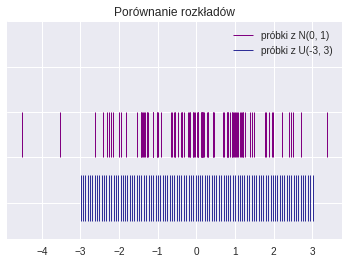

In [5]:
# Samples
N = 100
B = 10
sample_range = 3

xs = np.linspace(-3, 3, N)
g_samples = g.sample(N)
z_samples = z.sample(N)

# Plot distributions 
m = 0.02
plt.vlines(g_samples, ymin=-0.05,    ymax=-0.0,      color='purple', linewidth = 1, label='próbki z N(0, 1)');
plt.vlines(z_samples, ymin=-0.1 - m, ymax=-0.05 - m, color='navy', linewidth = 1, label='próbki z U(-3, 3)', alpha=.8);

# Make it pretty
## hide y ticks
ax = plt.gca()
ax.axes.get_yaxis().set_ticklabels([])

plt.ylim(top=0.1, bottom = -0.1 - 2*m);
plt.title('Porównanie rozkładów');
plt.legend() ;

In [0]:
from typing import Optional
from math import ceil

def plot_densities(g_samples,
                   d_values: Optional[np.ndarray] = None,
                   sample_range: Optional[float] = None,
                   loc: float = 0, scale: float = 1.5,
                   m: float = 0.01, 
                   B: int = 10):
    # Samples
    plt.vlines(g_samples, ymin=-0.05, ymax=-0.0, color='purple', linewidth = 1, label='próbki z N(0, 1)');

    # Plot the generated distribution
    ## True density
    if not sample_range:
      sample_range = ceil(max(np.max(g_samples), np.abs(np.min(g_samples))))
    
    xs = np.linspace(-sample_range, sample_range, len(g_samples))
    plt.plot(xs, norm.pdf(xs, loc=loc, scale=scale), 
             'r-', color='violet', alpha=0.6,
             label='Funkcja gęstości N(0, 1)')

    ## Empirical density
    hist, edges = np.histogram(
        g_samples, bins = B, density=True, 
        range=(-sample_range, sample_range))
    
    plt.plot(np.linspace(-sample_range, sample_range, B), hist, 
             '.--', color='purple', 
             label='E. func. gęstości N(0,1 )');
    
    ## Discriminator values
    if not d_values is None:
      xs = np.linspace(-sample_range, sample_range, len(d_values))
      plt.plot(xs, d_values, alpha=0.8, label='Discriminator values')

    # Make it pretty
    ## hide y ticks
    ax = plt.gca()
    ax.axes.get_yaxis().set_ticklabels([])

    plt.ylim(top=1.01, bottom = -0.1 - 2*m)
    plt.title('Porównanie rozkładów')
    plt.legend() 

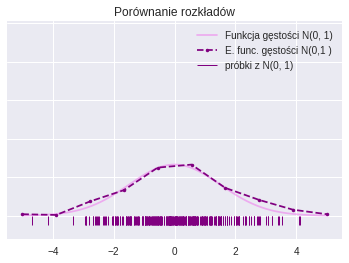

In [7]:
plot_densities(g.sample(256))


# Generative Adversarial Network

In [0]:
import torch
import torch.nn as nn

from torch import Tensor


def init_weights(module):
    ''' initializes the weights '''
    for name, param in module.named_parameters():
        if 'bias' in name:
            nn.init.constant_(param, 0.0)
        elif 'weight' in name:
            nn.init.xavier_normal_(param)


class Generator(nn.Module):
    def __init__(self, 
                 input_dim: int = 1, 
                 hidden_dim: int = 32, 
                 output_dim: int = 1):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
          nn.Linear(input_dim, hidden_dim, bias=True), nn.ReLU(),
          nn.Linear(hidden_dim, output_dim, bias=True)
        )
        self.apply(init_weights)
    
    def forward(self, x: Tensor) -> Tensor:
      '''
      Arguments:
        x - 2D tensor of shape B x 1
      
      Returns:
        2D tensor of shape B x 1 with transformed samples
      '''
      return self.net(x)

    
class Discriminator(nn.Module):
    def __init__(self, 
                 input_dim: int = 1, 
                 hidden_dim: int = 32, 
                 output_dim: int = 1):
        super(Discriminator, self).__init__()
        
        # 1 -> 8 -> 1 in (0, 1)
        self.net = nn.Sequential(
          nn.Linear(input_dim, hidden_dim, bias=True),  nn.ReLU(),
          nn.Linear(hidden_dim, output_dim, bias=True), nn.Sigmoid()
        )
     
        self.apply(init_weights)
      
    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)
        
      

# Optymalizacja

$$
\min_G \max_D V(D, G) = 
 \mathbb{E}_{x \sim p_{data}(x)}[\log(D(x))] + 
 \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
$$

In [0]:
def target(value: int, batch_size:int , device='cpu') -> Tensor:
    '''
    Tensor containing target value, with shape = (batch_size, )
    '''
    return torch.full((batch_size, 1), value, device=device)

In [0]:
import torch.optim as optim
from torch.autograd import Variable

batch_size = 256
num_epochs = 3000

# Distributions
mu, sigma = 0.0, 1.0
g = Gaussian(mu, sigma)
latent = Noise(5)

# Models
G = Generator(hidden_dim=32)
D = Discriminator(hidden_dim=32)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
G.to(device)
D.to(device)

# Loss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
lr = 0.001   # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

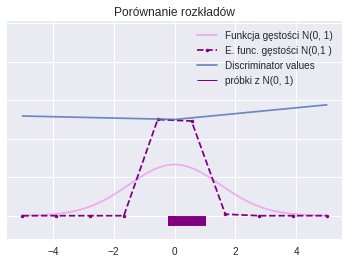

In [11]:
# Before training
g_sample = G(Tensor(latent.sample(batch_size)))
d_sample = D(Tensor(np.linspace(-5,5, batch_size).reshape(-1, 1)))

plot_densities(
    g_sample.detach().numpy(), 
    d_sample.detach().numpy(),
    sample_range=5
)

0 0.065543875
100 0.0080195
200 0.00202311
300 0.0010409164
400 0.0007755761
500 0.0005224747
600 0.00052930135
700 0.00043429772
800 0.00033747632
900 0.00033584487


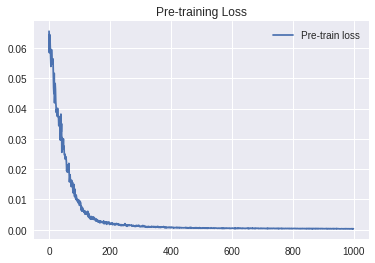

In [12]:
# Pre-training discriminator
num_epochs_pre = 1000

# optimizer
optimizer = torch.optim.Adam(D.parameters(), lr=lr)

# Loss function
pre_criterion = nn.MSELoss()

D_pre_losses = []
for epoch in range(num_epochs_pre):
    # Generate samples
    x = Variable(Tensor(g.sample(batch_size)))
    y = Variable(Tensor(norm.pdf(x, loc=mu, scale=sigma)))

    # Train model
    optimizer.zero_grad()
    D_pre_decision = D(x)
    D_pre_loss = pre_criterion(D_pre_decision, y)
    D_pre_loss.backward()
    optimizer.step()

    # Save loss values for plot
    D_pre_losses.append(D_pre_loss.item())

    if epoch % 100 == 0:
        print(epoch, D_pre_loss.data.numpy())
        

# Plot loss
plt.plot(D_pre_losses, label='Pre-train loss')
plt.title("Pre-training Loss")
plt.legend()
plt.show()

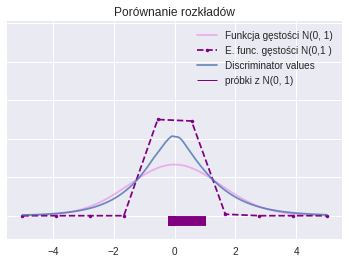

In [13]:
# After pre-training
d_sample = D(Tensor(np.linspace(-5,5, batch_size).reshape(-1, 1)))

plot_densities(
    g_sample.detach().numpy(), 
    d_sample.detach().numpy(),
    sample_range=5
)

0 1.7862122 1.0052471
100 1.4615202 0.81786406
200 1.4435041 0.66541946
300 1.3970227 0.6805985
400 1.2973225 0.868274
500 1.1985195 0.91017956
600 1.3293848 0.85238093
700 1.578769 0.5157156
800 1.1352895 0.9727053
900 1.4979358 0.63653374
1000 1.2765889 0.8468621
1100 1.4319103 0.6358479
1200 1.1210039 0.93266404
1300 1.5852882 0.5736989
1400 1.1998729 1.012677
1500 1.3749828 0.6319571
1600 1.3044744 0.7603191
1700 1.1596272 0.87711656
1800 1.5757098 0.60762954
1900 1.2490562 0.9478695
2000 1.1886727 0.8789513
2100 1.2671227 0.7382328
2200 1.5806811 0.5852554
2300 1.4118037 0.88006943
2400 1.3651061 0.78052145
2500 1.3985752 0.6589022
2600 1.3801782 0.666198
2700 1.3961005 0.6864192
2800 1.3835107 0.72973335
2900 1.384237 0.6987182


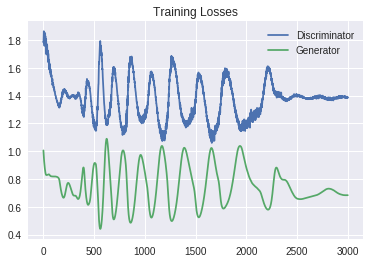

In [14]:
optimizerD = optim.Adam(D.parameters(), lr=lr)
optimizerG = optim.Adam(G.parameters(), lr=lr)


D_losses, G_losses = [], []
for epoch in range(num_epochs):
  ############################
  # 1 Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
  ############################
  
  # Zero the gradients
  D.zero_grad()

  # 1.1 Train on real Data
  # Generate batch of real examples
  x = Variable(Tensor(g.sample(batch_size)))
  
  # Forward the batch of reals through Discriminator
  D_real = D(x)
  
  # Calculate D's loss on all-real batch
  D_loss_real = criterion(D_real, target(1, batch_size, device))
  
  # Calculate gradients for D in backward pass
  D_loss_real.backward() 
 
  # 1.2 Train with fake data
  # Generate batch of latent vectors
  z = Variable(Tensor(latent.sample(batch_size)))
  
  # Generate batch of fake numbers and classify it
  D_fake = D(G(z))
             
  # Calculate D's loss on fake batch
  D_loss_fake = criterion(D_fake, target(0, batch_size, device))
             
  # Calculate gradients for D in backward pass
  D_loss_fake.backward()
  
  # Add the gradients from the all-real and all-fake batches
  D_loss = D_loss_real + D_loss_fake
 
  # Update paramaters of the discriminator
  optimizerD.step()
  
  ############################
  # 2 Train Generator: maximize log(D(G(z)))
  ############################
  # Zero the gradients
  D.zero_grad()
  G.zero_grad()
  
  
  # Generate batch of latent vectors
  z = Variable(Tensor(latent.sample(batch_size)))
  
  # Generate batch of fake numbers and classify it
  # Note: We updated D, perform another forward pass of fake batch through D
  D_fake = D(G(z))  
  
  # Calculate G's loss
  # Note: fake labels are real for generator cost
  G_loss = criterion(D_fake, target(1, batch_size, device))
  
  # Calculate gradients for D in backward pass
  G_loss.backward()
  
  # Update paramaters of the generator
  optimizerG.step()
  
  # Save loss values for plot
  D_losses.append(D_loss.item())
  G_losses.append(G_loss.item())
  
  if epoch % 100 == 0:
    print(epoch, D_loss.data.numpy(), G_loss.data.numpy())

# Plot losses
fig, ax = plt.subplots()
D_losses = np.array(D_losses)
G_losses = np.array(G_losses)
plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

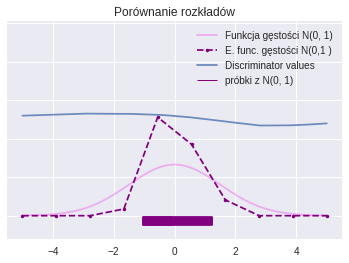

In [15]:
# After training
g_sample = G(Tensor(latent.sample(batch_size)))
d_sample = D(g_sample)

plot_densities(
    g_sample.detach().numpy(), 
    d_sample.detach().numpy(),
    sample_range=5
)